In [ ]:
import sys,os,time
sys.path.append("/usr/local/lib/python2.7/dist-packages")
import pyspark
from pyspark.sql import functions as F
from pyspark.sql import SparkSession,Row,Column
from pyspark.sql.types import *


spark = SparkSession.builder.appName("SparkStreamingExamples").getOrCreate()

# Capítulo 21. Básico de Structured Streaming


## Intro

<div style="text-align: justify">
<p>
    Strucutured Streaming é a API mais recente do projeto Apache Spark para processamento em stream. Sua principal característica é a capacidade de integração com Dataframes e Datasets o que torna tudo muito familiar para quem já trabalha com Spark fora do contexto de streaming.
</p>

<p>
    Outra característica dessa API é que o processamento dos dados de streaming ocorre de forma semelhante ao processamento em batch, embora os dados sejam disponibilizados a partir de um *stream*, de fato. Isso signficia que além das features de stream específicas estão disponíveis também as mesmas features de Dataframes e Datasets.
</p>

<p>
    Uma maneira de ver enxergar a idéia do processamento via Structured Stream é tratar o stream de dados como uma tabela(de forma análoga a como se trata dados em um Dataframe ou Dataset). Porém, mantenha em mente que essa tabela é constantemete atualizada. Cada consulta pode ser especificada em batch ou streaming. Internamente a API Structured Stream irá "entender" como incrementar os dados para sua consulta, de forma que seja tolerante à falhas.
</p>


</div>


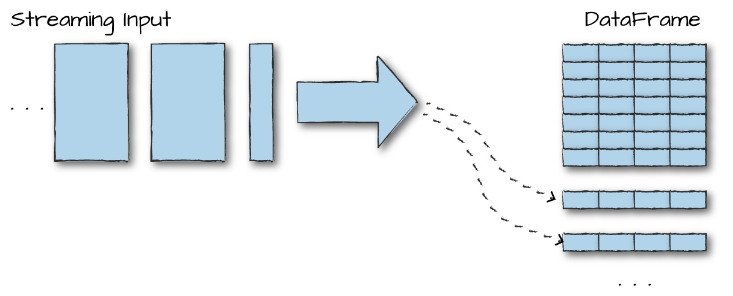



<div style="text-align: justify">
<p>
    Em termos simples, seu Dataframe, por exemplo, continua sendo um Dataframe, só que atualizado continuamente via stream. Claro que há limitações sobre consultas que você pode fazer, devido a própria natureza do streaming. Mas o que se quer que se mantenha em mente é que você pode manipular dados de streaming usando Dataframes usando a API Strucutred Streaming.
</p>


## Fontes de entrada ou *source*

<div style="text-align: justify; padding-top: 10px;">
<p>
    Entenda uma *source* como "drivers" de **leitura** de dados, ou *reader*. Alguns que são disponibilizados hoje:
</p>

</div>


* Apache Kafka 0.10

* Sistemas de arquivo distribuídos como HDFS ou S3

* Sockets

<div style="text-align: justify; padding-top: 10px;">

<p>
    Uma *source* é o ponto de contato com a fonte de dados é exatamente a "ponta de entrada". Você pode fazer transformações antes de enviar para uma *sink*(que veremos a seguir). 
</p>

<p>
    Para implementar uma *source*, utiliza-se uma propriedade da **sessão do spark** chamada *readStream*.
</p>

</div>

<br />
Ex:
   <br />
```
spark.readStream\
    .schema(someStaticDataFrameSchema)\
    .options("maxFilesPerTrigger",1)
    .json('/data/jsonDir/')
```




## Saída de dados ou *sink*


### O que é Sink ?

<div style="text-align: justify; padding-top:10px;">
<p>
    
    Em tradução livre, "pia". Em termos técnicos(e úteis), sinks são como "drivers" para *escrita* de dados ou *writers*. Alguns que estão disponíveis:
</p>

</div>

   * *kafka*, ou seja, o driver para o Spark Apache Kafka 0.10
    
   * praticamente **todos** os formatos de arquivos e sockets
    
   * *foreach* para executar computação arbitrária em registros de saída
    
   * *console* para testes
    
   * *memory* para debugging


<div style="text-align: justify">

<p>
    Pode-se pensar numa *sink* como um repositório de dados do stream. Uma vez estabelecido, o sistema de streaming passa a ler dados do *source* e escrever dados na *sink*. Desse modo, estabelece-se o fluxo de dados, e a partir da sink obtem-se os dados conforme o tipo de consulta que se quer da *source*. Dessa forma, pode-se criar várias *sinks* diferentes com filtros e transformações diferentes da mesma *source*, com a vantagem de não ser necessário ter absolutamente todos os dados disponíveis de uma vez, o que exigiria uma quantidade de memória e/ou espaço em disco normalmente não-disponível dentro do contexto de Bigdata. Isso é eficiência!
</p>

<p>
    
    Para utilizar uma *sink*, deve-se implementar uma propriedade do dataframe chamada *writeStream*, como demostrado mais abaixo.
</p>

</div>

<br />
Ex:
   <br />
```
spark.writeStream\
.format('kafka')\
.options(...)\
.start()

```

<div style="text-align: justify; padding-top:10px;">
<p>
    
    Repare que o método *start()* deve ser implementado, afim de iniciar o fluxo de entrada e saída de dados. Novas modificações nesse fluxo devem ser implementadas como um novo fluxo de entrada e saída no stream de dados.
</p>

</div>


## Modos de saída

<div style="text-align: justify">

<p>
    Assim como se define como os dados vão entrar, também devemos definir como os dados vão sair. No caso de streaming isso vai um pouco além. Defininmos também **quais** dados vão sair. As opções são:
  

</p>

</div>


* *append*( somente novos registros vão para a sink )

* *update*( atualiza os dados modificados )

* *complete*( reescreva TUDO o que está na sink )


<div style="text-align: justify">

<p>
    Note que alguns tipos de consulta estão disponíveis em alguns tipos de sinks, como consultas do tipo *map*, por exemplo. 

</p>

</div>




## Processamento em "tempo de evento"

<div style="text-align: justify">
<p>
        Structured Streaming também suporta processamento de dados em *tempo de evento*(ex: dados processados com base no timestamp que podem chegar fora de ordem). Existem duas idéias-chave que vocẽ irá precisar comprender aqui neste momento: 
      
</p>
</div>

* *dados em tempo de evento*
<div style="text-align: justify">
<p>
Significa campos de tempo que são "embuídos" no seu dado. Isto significa processar dados no tempo em que o dado foi gerado, ao invés de processar dados conforme eles vão chegando no seu sistema, ou seja, independentemente da ordem de chegada. Basicamente, uma coluna timestamp(ou outro formato de dado que expresse o momento de geração do dado), junto com o dado;
</p>
</div>
<div style="width:100%;padding-top: 20px;"></div>
* *marca d'água*
<div style="text-align: justify">
<p>
A *marca d'água* expressa intervalos de tempo ou "janelas" que limitam a informação que chega do streaming;
</p>
</div>


## Menos "conversa" e mais código!


#### Carregando dados no modo estático

<p>
Apenas para visualizar a diferença de como se carrega dados no modo *estático* e posteriormente, no modo *streaming*

</p>

In [ ]:
# Exemplo de leitura de dados em um ou mais arquivos em um diretório no HDFS:

static = spark.read.json("/data/activity-data/")
dataSchema = static.schema


Aqui, o esquema:

In [ ]:
print str(dataSchema)

Aqui, uma amostra do DataFrame

In [ ]:
static.show()

#### Carregando dados no "modo streaming"


<div style="text-align: justify;">
    <p>
        Abaixo, o código configura o streaming, partindo do princípio que Spark executa comandos no modo *lazy*, ou seja, podemos configurar e até aplicar algumas transformações antes de executar de fato. No caso de streaming, tudo começa a executar depois a partir da invocação do método *start()*, como será demonstrado mais adiante.

    </p>
    
    <p>
        Para a API Structured Streaming, a idéia é manter fluxos de dados, ou seja, entradas e saídas, que correspondam respectivamente, a configurar um *reader* e um *writer* para o streaming de dados. No código abaixo, um exemplo de um *reader* típico. Repare que está disponível a partir da própria sessão do Spark(pyspark.sql.SparkSession). A única diferença é que ao invés de obter a leitura do streaming de dados através da propriedade "read"(como no exemplo utilizado na seção "Carregando dados no modo estático"), usamos *readStream*.      
    </p>
    
</div>

In [ ]:
# Configurando a leitura do streaming de dados.
streaming = spark.readStream \
.schema(dataSchema) \
.option("maxFilesPerTrigger",1) \
.json("/data/activity-data")

In [ ]:
# Esse é o dado que efetivamente se quer ver, expresso na transformação abaixo. Mas isso não será executado agora! 
activityCounts = streaming.groupBy("gt").count()

In [ ]:
# Como se espera a execução disso em uma máquinia pequena ou mesmo numa VM, é razoável 
# configurar o número de partições em um valor pequeno.
spark.conf.set("spark.sql.shuffle.partitions",5)

Atendendo aos requisitos da API Structured Streaming, se existe um *readStream*, deve existir um *writeStream*. Em outras palavras, deve se definir como e o que será despejado na *sink*. Exemplo:

In [ ]:
# Configurando a escrita do resultado da transformação. 
# O nome 'activity_counts' estará disponível como uma entidade através do spark.sql como demonstrado mais adiante.
# o formato da 'sink' é 'memory', ou seja, os dados da sink serão despejados diretamente na memória
# o modo de escrita na sink é 'complete', ou seja, espera-se que TODOS os dados disponíveis do streaming 
# estejam na sink.
activityQuery = activityCounts.writeStream \
.queryName("activity_counts") \
.format("memory") \
.outputMode("complete") \
.start()
# O método 'start()' executa a consulta de forma assíncrona por padrão. Então, para evitar que outro processamento que seja 
# necessário sobrescreva algum resultado ou execute em um momento que não deveria, o método *awaitTermination()* é requerido. 
# Em outras palavras, é preciso "sinalizar" para o Spark, que se quer esperar até que o processamento do streaming 
# termine antes de executar algum código após a invocação do método *start()*.



O método *awaitTermination()* evita previne o processo de sair enquanto a query está ativa, mas não funciona no Jupyter. Por favor, leia a documentação indicada abaixo:

* https://stackoverflow.com/questions/55840424/spark-streaming-awaittermination-in-jupyter-notebook

* https://docs.databricks.com/spark/latest/structured-streaming/production.html

* http://spark.apache.org/docs/latest/structured-streaming-programming-guide.html

* https://docs.databricks.com/spark/latest/structured-streaming/demo-notebooks.html


In [ ]:
# activityQuery.awaitTermination()


<div style="text-align: justify">
    <p>
        E assim a configuração do fluxo de dados é definida, e o início é executado através do método *start()*. Repare que o *writer*(writeStream), possui uma propriedade chamada *queryName*. Essa propriedade é definida com o objetivo de identificar onde *spark.sql* irá recuperar dados no caso de uma consulta, de forma análoga como se identifica tabelas e views, como demonstrado mais adiante.  
    </p>
</div>

In [ ]:
# Exibe os streamings ativos na sessão do Spark.
print str(spark.streams.active)

In [ ]:
# Considere 
from time import sleep
for x in range(5):
    spark.sql("SELECT * FROM activity_counts").show()
    sleep(1)

#### Seleção e Filtros

<div style="text-align: justify">
    <p>
    Como dito anteriormente no capítulo 20 e 21, a API Structured Streaming disponibiliza os dados em objetos
    DataFrame "incrementáveis". Isso significa, basicamente, que você tem os métodos de seleção e filtros 
    (.select(),.filter(),.where(), etc.), estarão disponíveis. Basta apenas que novas queries sejam disponibilizadas em **um novo *writer* **(propriedade writeStream), ou seja, toda vez que você precisar de dados com uma nova seleção e filtragem, você deve disponibilizar isso em um novo *writer*. Exemplo:
    </p>
</div>

In [ ]:
from pyspark.sql.functions import expr
simpleTransform = streaming.withColumn('stairs',expr("gt like '%stairs%'"))\
.where("stairs")\
.where("gt is not null")\
.select("gt","model","arrival_time","creation_time")\
.writeStream\
.queryName("simple_transform")\
.format("memory")\
.outputMode("append")\
.start()

<div style="text-align: justify">
    <p>
    Aqui, a referência para o novo conjunto de dados é *simple_transform*. Esse novo dataset foi gerado
    a partir de um **novo writer**, de forma análoga ao que foi referenciado pelo nome *activity_counts*, e melhor!
    Ambos como objetos *DataFrame*, o que permite praticamente tudo o que está disponível via módulo `spark.sql` como agregações, joins, etc..
    </p>
</div>

In [ ]:
spark.sql("SELECT * from simple_transform").show()

In [ ]:
#activityQuery.stop()

### Agregações

<div style="text-align: justify;padding-top: 10px;">
    <p>
    Structured Streaming suporta agregações! Já vimos isso quando usamos 'count', que é um método de agregação, certo? Agora, veremos as agregações de outra maneira mais 'exótica' montando um 'cubo' com as médias das acelerações dos sensores(No capítulo 7 tem mais detalhes sobre possíveis agregações no Spark). 
    </p>

</div>

In [ ]:
deviceModelStats = streaming.cube("gt","model").avg()\
                    .drop("avg(Arrival_time)")\
                    .drop("avg(Creation_Time)")\
                    .drop("avg(Index)")\
                    .writeStream.queryName("device_counts")\
                    .format("memory")\
                    .outputMode("complete")\
                    .start()

In [ ]:
# Checando o writer
spark.sql("SELECT * from device_counts where model IS NOT NULL").show()

### Joins
<div style="text-align: justify;padding-top: 10px">
    <p>
    A partir da versão 2.3 do Spark, é possível implementar *joins* com múltiplos streams e também incluir objetos DataFrame estáticos no mesmo join!  
    </p>

</div>


In [ ]:
# Exemplo de join de um DataFrame estático(static) com um streaming
historicalAgg = static.groupBy("gt", "model").avg()
deviceModelStats = streaming.drop("Arrival_Time", "Creation_Time", "Index")\
.cube("gt", "model").avg()\
.join(historicalAgg, ["gt", "model"])\
.writeStream.queryName("device_counts2").format("memory")\
.outputMode("complete")\
.start()


In [ ]:
historicalAgg.show()

### Lendo de sources e escrevendo em sinks

<div style="text-align: justify;padding-top:10px;">
    <p>
        Nessa seção, vamos falar um pouco mais especificamente sobre alguns tipos de fluxo de entrada e saída utilizando *source* e *sink*
    </p>
</div>

#### Sink Kafka

<div style="text-align: justify;padding-top:10px;">
   <p>
        Como já sabemos, para lidar com streams, temos entradas de dados(*source*), que são implementadas através da propriedade *readStream*. No caso do Kafka isso também é verdade, porém, existem especificidades a se considerar. Cada registro do Kafka traz, minimamente: chave, valor e o momento(timestamp) em que o registro foi gravado no stream de dados. Existem também os *tópicos*, que são divisões imutáveis de segmentos de dados identificáveis pelo Kafka através de strings. 
        
   </p>
</div>    
    

   <p>
     A **leitura** de dados em um *tópico* do Kafka é chamada de *subscribing*(inscrição em tradução livre para o português).
    </p>
    
   <p> Na leitura, é possível ser mais preciso quanto aos dados que se quer trazer no streaming, incluindo dados de vários tópicos de uma vez. Para isso utiliza-se *assign*, passando os intervalos de dados e os tópicos.
    
    </p>
    
    
    
</div>

* Ex: {"topicA":[0,1], "topicB":[2,4]};


<div style="text-align: justify;padding-top:10px;">
    <p>
    Ou, pode-se obter dados através das opções *subscribe* e *subscribePattern*.
    </p>
</div>

* Exemplo de *subscribe*: "produtos.eletro"  
<br />
* Exemplo de *subscribePattern*: "produtos.*"  

<p>
    Outro detalhe a se considerar, é a origem dos dados. Para o caso do Kafka, utiliza-se a opção "kafka.bootstrap.servers" para determinar uma ou várias origems de dados(no caso de várias, separa-se por ',').

</p>


<p>
    A opção *failOnDataLoss* define se o streaming será abortado ou não em caso de falha(True ou False). Por padrão a opção é True.
</p>



<p>
    Outras opções na documentação de [Integração do Spark 2.3.2 com o Kafka](https://spark.apache.org/docs/2.3.2/structured-streaming-kafka-integration.html)
    
    

</p>

<p>
    Se nehuma transformação de dados é necessária, basta invocar o método *load()*
</p>

<p> 
    Cada linha de uma *source* tem o seguinte esquema(schema):
</p>    
* key: binary
<br />
* value: binary
<br />
* topic: string
<br />
* partition: int
<br />
* offset: long
<br />
* timestamp: long




#### Exemplos de leitura de dados de uma *source* Kafka


```
# Inscrição(subscribing) em 1 tópico
df1 = spark.readStream.format("kafka")\
  .option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
  .option("subscribe", "topic1")\
  .load()

```




```
# Inscrição(subscribing) em múltiplos tópicos
df2 = spark.readStream.format("kafka")\
  .option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
  .option("subscribe", "topic1,topic2")\
  .load()

# Inscrição(subscribing) usando padrões
df3 = spark.readStream.format("kafka")\
  .option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
  .option("subscribePattern", "topic.*")\
  .load()

```








<div style="text-align: justify;padding-top: 10px">
<p>

A **escrita** dados em um *tópico* é chamada de *publishing*(publicação em tradução livre para o português).

</p>
</div>

<div style="text-align: justify;padding-top:10px;">
    <p>
    As opções no caso de leitura seriam:
    
    </p>
    
</div>

* *kafka.bootstrap.servers*: define os endereços dos nós do cluster que podem ser usados para gravar os dados;
<br />
<br />

* *checkpointLocation* não é uma opção exclusiva do Kafka(faz parte da API Strucutred Streaming), porém no caso do Kafka pode ser usada como implementação de tolerância à falhas, podendo salvar informações no HDFS/S3 etc. e usar esses dados como referência para recuperar dados do streaming posteriormente. 


#### Exemplos de escrita em uma *sink* Kafka

```
df1.selectExpr("topic", "CAST(key AS STRING)", "CAST(value AS STRING)")\
  .writeStream\
  .format("kafka")\
  .option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
  .option("checkpointLocation", "/to/HDFS-compatible/dir")\
  .start()
 
  
df1.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")\
  .writeStream\
  .format("kafka")\
  .option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
  .option("checkpointLocation", "/to/HDFS-compatible/dir")\
  .option("topic", "topic1")\
  .start()
  
```

### Sources e Sinks para teste

<div style="text-align: justify; padding-top: 10px">
    <p>
        Spark também fornece sinks para teste, prototipação e debugging de consultas. São eles:
    </p>

</div>

#### Socket source

<div style="text-align: justify; padding-top: 10px">
    <p>
        Estabelecendo a leitura do streaming. Nesse caso, uma conexão socket local.
    </p>

</div>

In [ ]:
socketDF = spark.readStream.format("socket")\
.option("host","localhost")\
.option("port",9999)\
.load()

<div style="text-align: justify; padding-top: 10px">
    <p>
        Estabelecendo o "despejo" dos dados em uma *sink* tipo **socket**
    </p>

</div>

In [ ]:
socketDF.writeStream\
.format("memory")\
.queryName("socket_stream")\
.start()

<div style="text-align: justify; padding-top: 10px">
    <p>
        Usando o netcat(Linux), vamos gravar alguns dados no socket, para que o flu
    </p>

</div>

In [ ]:
spark.sql("SELECT * FROM socket_stream").show()   

### Output Modes

<div style="text-align:justify;padding-top:10px">
    <p>
        Agora que sabemos **onde** os dados fluem no fluxo de streaming(*sources e sinks*), falta detalhar um pouco mais sobre **como** os dados são gravados numa *sink*. Para isso utiliza-se uma opção da propriedade *writeStream* chamada *outputMode*. Como já foi mencionado anteriormente, esses modos de saída podem ser:  
    </p>

</div> <br />

* **Append mode:** é o modo "padrão"! Quando novas linhas são adicionadas à fonte de dados, já transformadas, filtradas etc, eventualmente elas serão despejadas numa *sink*. Esse modo garante que ela será despejada na *sink* **apenas uma vez**, assumindo que você implementou um *sink* tolerante à falhas. <br />

* **Complete mode:** Independente do estado atual do dado no stream, ele será despejado na *sink*. 
 
* **Update mode:** Semelhante ao modo completo, exceto que apenas as linhas modificadas do estado anterior serão despejadas na *sink*



#### Quando usar cada modo?

<div style="text-align:justify;padding-top:10px">
    <p>
        Basicamente a escolha do modo limita o tipo de query que você pode fazer. Por exemplo, se você precisa apenas de operações do tipo *map*, a API Structured Streaming não irá permitir o modo *complete*, porque isso iria requerer obter todos os dados desde o início do job e reescrever toda a tabela de saída. Esse requisito é proibitivamente caro em termos de recurso. Abaixo uma tabela que resume tipos de operação e algumas situações suportadas para cada modo de saída.
    </p>

</div> <br />




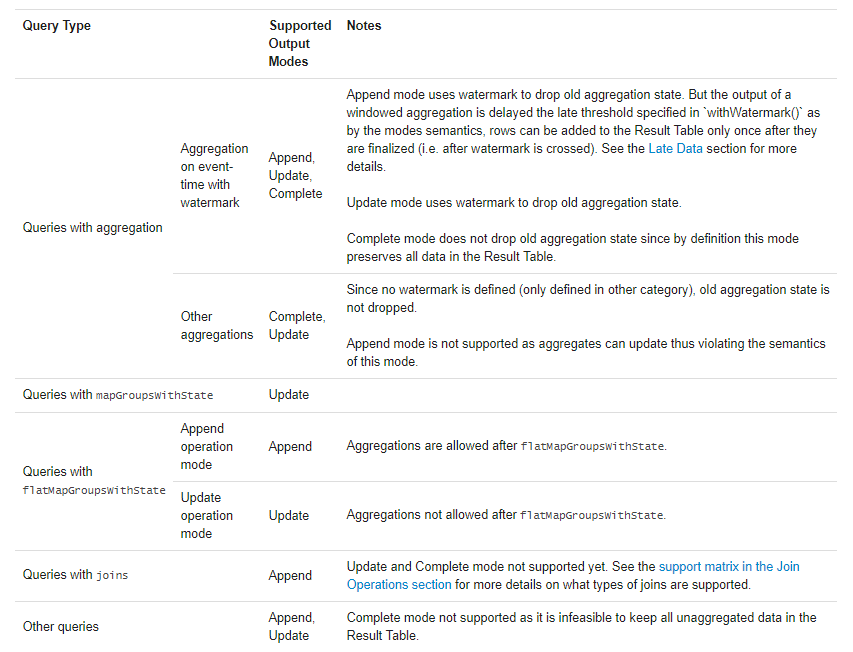